# Anomaly detection using normalizing flows

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
from einops import rearrange
from inspectorch.plot_params import set_params
from inspectorch import genutils
from inspectorch import flowutils

In [2]:
# Suppress some warnings for cleaner output
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Set matplotlib plotting parameters for consistent style
set_params()

In [4]:
# Print device info for debugging and reproducibility
genutils.device_info()

CUDA is not available. Using CPU.


## Data

In [5]:
# --- Data loading and preprocessing ---

# Read the compressed Hinode data from file
with np.load("hinode_data.npz") as npzfile:
    data = npzfile["data"]
    wav = npzfile["wav"]
    pixel_size = npzfile["pixel_size"] * 3.0

ny, nwav, nx = data.shape
print(f"Data shape: {data.shape}")

# Normalize data by quiet sun (QS) median value for consistent intensity scaling
qs = np.median(data[:, 0, :])
data = data / qs
average = np.mean(data[:, :, :], axis=(0, 2))

Data shape: (342, 30, 254)


In [6]:
# --- Dataset preparation ---

# Wrap the data in a patched dataset for spectral analysis
dataset = flowutils.GeneralizedPatchedDataset(
    data,
    dim_names="y wav x",  # Define the dimensions of the dataset
    feature_dims=["wav"],  # Specify the feature dimensions for spectral analysis
)

print(f"Data (patched) shape: {dataset.shape}")

Dataset initialized with 86868 samples.
Each sample is a flattened vector of size 30.
Data (patched) shape: torch.Size([86868, 30])


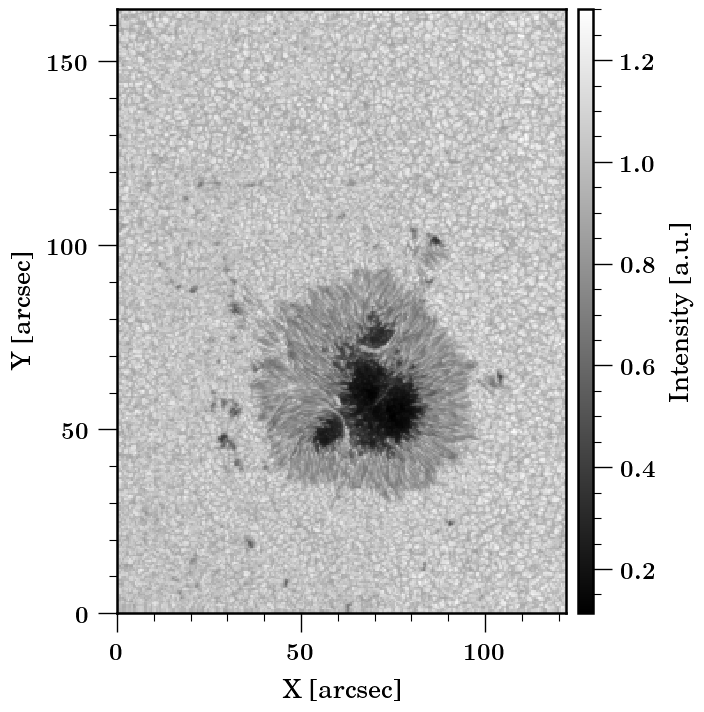

In [7]:
# --- Visualization of raw data ---

plt.figure(figsize=(8, 8))
extent = np.array([0, data.shape[2], 0, data.shape[0]]) * pixel_size
plt.imshow(
    data[:, 0, :], cmap="gray", vmin=None, vmax=1.3, extent=extent, origin="lower"
)
plt.minorticks_on()
plt.xlabel("X [arcsec]")
plt.ylabel("Y [arcsec]")
cb = plt.colorbar(pad=0.02, shrink=1.0, aspect=40)
cb.set_label("Intensity [a.u.]")
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=5)

## Data preparation

In [8]:
# --- Data preparation for training ---

# Create a dot_dict for training arguments
args = flowutils.dot_dict()
args.batch_size = 10000

# Create a DataLoader for efficient batch training
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=args.batch_size, shuffle=True
)

## Density estimation

In [9]:
# Build the normalizing flow model for density estimation
model = flowutils.Density_estimator()

# Create a normalizing flow with specified architecture
model.create_flow(
    input_size=dataset.flow_dim, num_layers=5, hidden_features=32, num_bins=8
)

In [10]:
# Print model summary for inspection
model.print_summary()

Total params to optimize: 75625


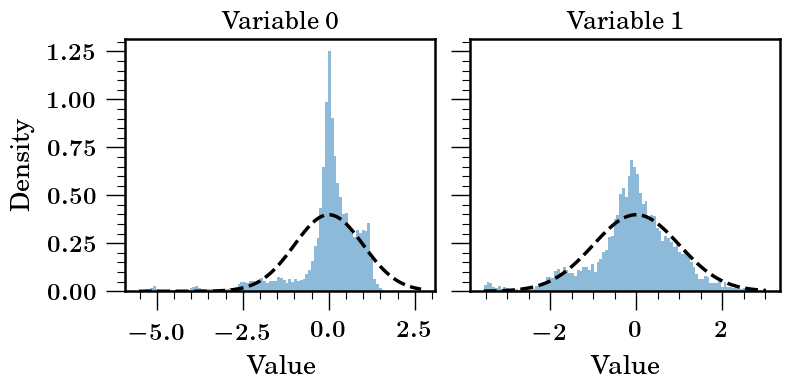

In [11]:
# Visualize data distribution before training
model.check_variables(train_loader, plot_variables=[0, 1], figsize=(8, 4))

## Training the density estimator

In [12]:
# Set training hyperparameters
args.learning_rate = 1e-3
args.num_epochs = 15
args.device = "cuda:0"
args.output_model = "models/nflow_model_hinode_mini.pth"
args.save_model = True
args.load_existing = True

# Save training arguments for reproducibility
genutils.save_json(args, "models/nflow_args_hinode_mini.json")

# Train the normalizing flow model
model.train_flow(
    train_loader=train_loader,
    learning_rate=args.learning_rate,
    num_epochs=args.num_epochs,
    device=args.device,
    output_model=args.output_model,
    save_model=args.save_model,
    load_existing=args.load_existing,
)

Device: CUDA specified, but torch.cuda.is_available() is False. Falling back to CPU.


Epoch 15/15: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s, Loss: -34.86]


Completed training in 0.63 minutes.
Model saved to models/nflow_model_hinode_mini.pth


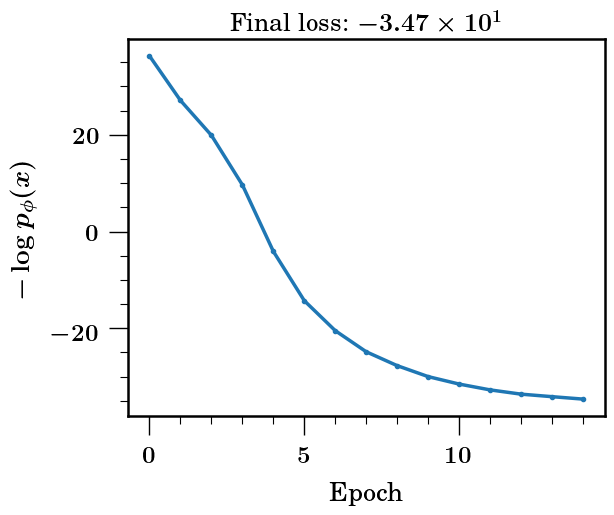

In [13]:
# Plot training loss to monitor convergence
model.plot_train_loss()

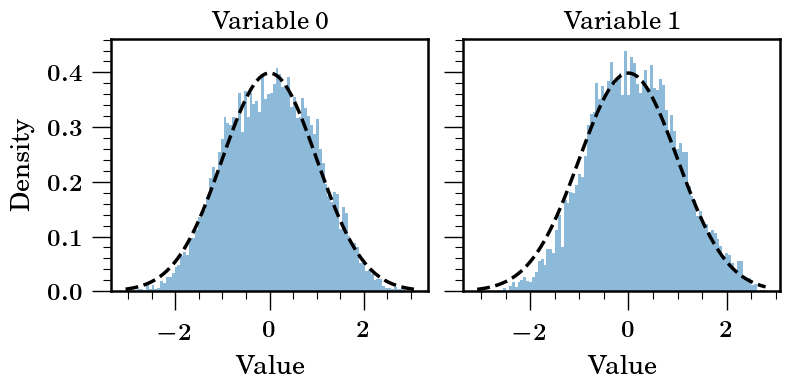

In [14]:
# Visualize data distribution after training
model.check_variables(train_loader, plot_variables=[0, 1], figsize=(8, 4))

## Evaluating the model

In [15]:
# Compute log-probabilities for all data points
log_prob = model.log_prob(dataset)


# The model evaluated all the dataset, so we need to reshape the log_prob
# to match the original dimensions of the data

# Reshape log_prob to match original spatial dimensions
log_prob_reshaped = rearrange(log_prob, "(y x) -> y x", y=ny, x=nx)

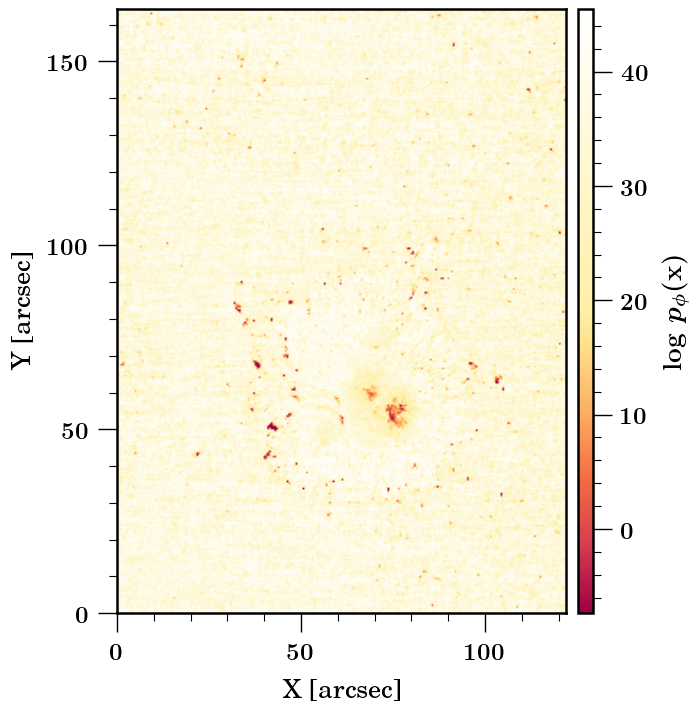

In [16]:
# Plot spatial distribution of log-probabilities
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
spectral_to_white = genutils.create_spectral_to_white_cmap()

im = ax.imshow(
    log_prob_reshaped,
    cmap=spectral_to_white,
    vmin=0.1 * np.min(log_prob_reshaped),
    vmax=0.9 * np.max(log_prob_reshaped),
    origin="lower",
    interpolation="bilinear",
    extent=extent,
)
cb = fig.colorbar(im, ax=ax, pad=0.02, shrink=1.0, aspect=40)
cb.set_label(r"$\log\,p_\phi(\mathbf{x})$")
plt.minorticks_on()
plt.xlabel("X [arcsec]")
plt.ylabel("Y [arcsec]")
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=5)

Least common spectra indices: [26503 26757 26251 35385 35892]


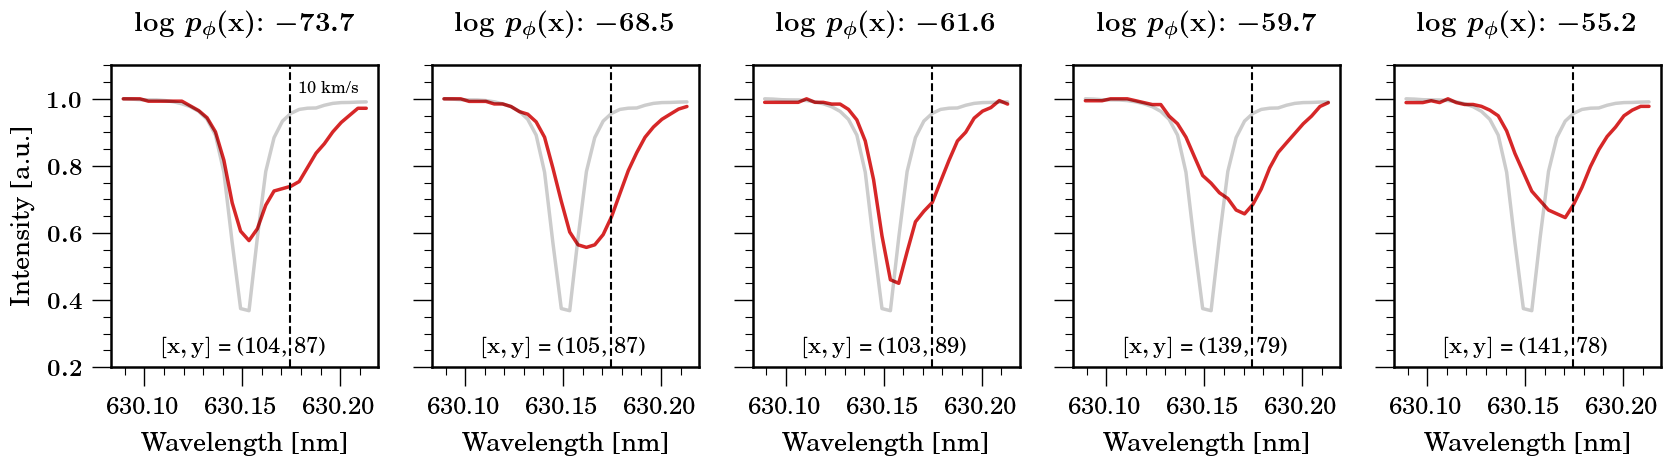

In [17]:
# --- Visualization of least common spectra ---

nplots = 5

# Find indices of least probable spectra
idxs = np.argsort(log_prob)[:nplots]
print(f"Least common spectra indices: {idxs}")

fig, ax = plt.subplots(1, 5, figsize=(20, 16 / 4 * 1), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(nplots):
    # Plot normalized spectrum for each least common sample
    ax[i % 5].plot(wav / 10, dataset[idxs[i]] / torch.max(dataset[idxs[i]]), color="C3")
    ax[i % 5].plot(
        wav / 10, average / np.max(average), ls="-", color="black", alpha=0.2
    )

    ax[i % 5].set_title(
        r"$\log\,p_\phi(\mathbf{{x}})$: ${0:.1f}$".format(log_prob[idxs[i]]),
        fontsize=20,
        fontweight="bold",
        loc="center",
        pad=25,
    )
    # Annotate spatial location of each spectrum
    ax[i % 5].text(
        0.5,
        +0.1,
        r"$\mathbf{{[x,y]}}$ = ({0}, {1})".format(idxs[i] // nx, idxs[i] % nx),
        fontsize=16,
        ha="center",
        va="top",
        transform=ax[i % 5].transAxes,
    )

    # Only set ylabel for the first column
    if i % 5 == 0:
        ax[i % 5].set_ylabel("Intensity [a.u.]")
    ax[i % 5].set_xlabel("Wavelength [nm]")

    # Add velocity axis at the top for reference
    cc = 299792.458  # speed of light in km/s
    line = (
        wav[len(wav) // 2] / 10
    )  # reference wavelength in nm (choose center or a specific value)

    # Draw a vertical line at 10 km/s on the secondary axis
    v_line = 10  # km/s
    lambda_v = line + (v_line * line / cc)
    ax[i % 5].axvline(lambda_v, color="k", linestyle="--", linewidth=1.5)
    # Add velocity label at the top of the plot
    if i == 0:
        ax[i % 5].text(
            lambda_v + 0.02,
            0.95,
            f"{v_line} km/s",
            fontsize=12,
            ha="center",
            va="top",
            color="k",
            transform=ax[i % 5].get_xaxis_transform(),
        )

for axes in ax.flat:
    axes.ticklabel_format(style="plain", axis="x", useOffset=False)

# Set y-axis limits for all subplots for consistency
for axes in ax.flat:
    axes.set_ylim(0.2, 1.1)


# Format x-axis tick labels to show a fixed number of decimals
num_decimals = 2
for axes in ax.flat:
    axes.set_xticklabels([f"{tick:.{num_decimals}f}" for tick in axes.get_xticks()])